In [1]:
import numpy as np
from numpy import random
from numpy import vstack
import pandas as pd
import os
print(os.listdir("../input"))
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import zipfile

['annotation', 'all-dogs']


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


# EDA - Load & prepare dataset

In [3]:
import glob
image = glob.glob('../input/all-dogs/all-dogs/*')
breed = glob.glob('../input/annotation/Annotation/*')
annot = glob.glob('../input/annotation/Annotation/*/*')
print(len(image), len(breed), len(annot))

20579 120 20580


In [4]:
def get_bbox(annot):
    """
    This extracts and returns values of bounding boxes
    """
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [5]:
def get_image(annot):
    """
    Retrieve the corresponding image given annotation file
    """
    img_path = '../input/all-dogs/all-dogs/'
    file = annot.split('/')
    img_filename = img_path+file[-1]+'.jpg'
    return img_filename

In [6]:
# initialize tensor for dog images
n_x = 64
n_c = 3
dogs = np.zeros((len(image), n_x, n_x, n_c))
print(dogs.shape)

(20579, 64, 64, 3)


In [7]:
for a in range(len(image)):
    bbox = get_bbox(annot[a])
    dog = get_image(annot[a])
    if dog == '../input/all-dogs/all-dogs/n02105855_2933.jpg':   # this jpg is not in the dataset
        continue
    im = Image.open(dog)
    im = im.crop(bbox[0])
    im = im.resize((64,64), Image.ANTIALIAS)
    dogs[a,:,:,:] = np.asarray(im) / 255.

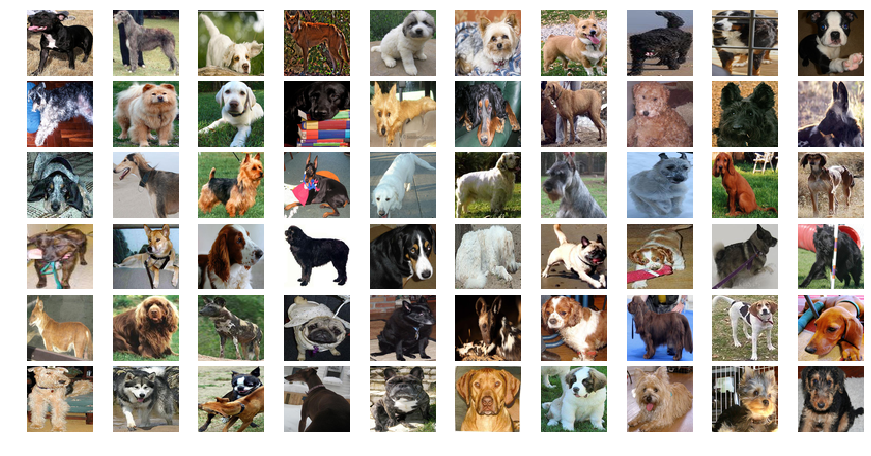

In [8]:
# pick some images randomly from dogs and look at these
plt.figure(figsize=(15,8))
n_images = 60
select = random.randint(low=0,high=dogs.shape[0],size=n_images)
for i, index in enumerate(select):  
    plt.subplot(6, 10, i+1)
    plt.imshow(dogs[index])
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

**Best Practice:** To scale the pixel values from the range of [0,1] to the normalized range of [-1,1]. The generator model will generate images with pixel values in the range [-1,1] as it will use the tanh activation function, a best practice. Hence, the real images are to be scaled to the same range.

In [9]:
# scale from [0,1] to [-1,1]
dogs = (dogs*2)-1

# The Discriminator

The discriminator takes a sample "image" from our dataset and says whether it is real or fake.

**Inputs:** "image" 64x64 pixels in size; three channels (RGB).

**Outputs:** binary classification, likelihood the sample is real.

### Define the Discriminator

In [10]:
def define_discriminator(in_shape=(n_x,n_x,n_c)):
    """
    Define the conv net for the discriminator
    """
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    model.add(Conv2D(64,kernel_size=3,padding='same',input_shape=in_shape,kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(rate=0.4))
    model.add(Dense(1,activation='sigmoid'))
    opt = Adam(lr=0.0002,beta_1=0.5) # define optimizer
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

In [11]:
discriminator = define_discriminator()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         524544    
__________

### Training of the Discriminator

All image samples will be labelled '1' (real). Need to create fake samples labelled as '0'. The fake samples will be created by the Generator. The real and fake samples will be fed into the Discriminator by batches.

In [12]:
def generate_real_samples(data, n_samples):
    """
    Pick 'n_samples' randomly from 'data'
    """
    idx = random.randint(low=0,high=data.shape[0],size=n_samples)
    X = data[idx]
    Y = np.ones((n_samples,1))
    return X, Y

# The Generator

The Generator creates new, fake but plausible images. It works by taking a point from a latent space as input and output an image.

**Inputs:** Point in latent space, e.g. a 100-element vector of Gaussian random numbers.

**Outputs:** 2D color image (3 channels; RGB) of 64x64 pixels with pixel values in [-1,1].

In [13]:
def define_generator(latent_dim):
    """
    Define the conv net for the generator
    """
    init = RandomNormal(stddev=0.02)
    n_nodes = 128*8*8
    model = Sequential()
    model.add(Dense(n_nodes,input_dim=latent_dim,kernel_initializer=init)) # foundation for 8*8 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,128)))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init)) # up-sample to 16*16 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init)) # up-sample to 32*32 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init)) # up-sample to 64*64 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3,kernel_size=3,activation='tanh',padding='same',kernel_initializer=init))
    return model

In [14]:
latent_dim = 200 # define size of latent space
generator = define_generator(latent_dim)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              1646592   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
__________

In [15]:
def generate_latent_points(latent_dim, n_samples):
    """
    This generates points in the latent space as input for the generator
    """
    x_input = random.randn(latent_dim * n_samples)    # sample from normal/gaussian distribution (best practice)
    x_input = x_input.reshape(n_samples, latent_dim)     # reshape into a batch of inputs for the network
    return x_input

In [16]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    """
    Generate 'n_samples' of fake samples from the generator
    """
    X_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(X_input)    # generator predicts output
    Y = np.zeros((n_samples,1))     # create class labels '0' for fake sample
    return X, Y

# Combining the Discriminator & Generator as a GAN

In [17]:
def define_gan(g_model, d_model):
    """
    This takes as arguments the generator and discriminator and creates the GAN subsuming these two models. 
    The weights in the discriminator are marked as not trainable, 
    which only affects the weights as seen by the GAN and not the standalone discriminator model.
    """
    d_model.trainable = False     # make weights in the discriminator not trainable
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [18]:
gan = define_gan(generator, discriminator)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         2436867   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 936193    
Total params: 3,373,060
Trainable params: 2,436,867
Non-trainable params: 936,193
_________________________________________________________________


# Functions to evaluate performance of GAN

In [19]:
def save_plot(examples, epoch, n=10):
    """
    This creates and save a plot of generated images
    """
    examples = (examples+1)/2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    plt.title('Epoch %03d' % (epoch+1))
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [20]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, data, latent_dim, n_samples=100):
    """
    This evaluates the discriminator, plot generated images, save generator model
    """
    X_real, Y_real = generate_real_samples(data, n_samples)
    _, acc_real = d_model.evaluate(X_real, Y_real, verbose=0)   # evaluate discriminator on real samples
    X_fake, Y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(X_fake, Y_fake, verbose=0)   # evaluate discriminator on fake samples
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))    # summarize discriminator performance
    save_plot(X_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# Train the GAN

In [21]:
def train(g_model, d_model, gan_model, data, latent_dim, n_epochs=300, batch_size=128):
    """
    This trains the combined generator and discriminator models in the GAN
    """
    batch_per_epoch = data.shape[0] // batch_size
    half_batch = batch_size // 2
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, Y_real = generate_real_samples(data, half_batch)   # randomly select real samples
            d_loss1, _ = d_model.train_on_batch(X_real, Y_real)   # update discriminator model weights
            X_fake, Y_fake = generate_fake_samples(g_model, latent_dim, half_batch)   # generate fake samples
            d_loss2, _ = d_model.train_on_batch(X_fake, Y_fake)   # update discriminator model weights
            X_gan = generate_latent_points(latent_dim, batch_size)   # as input for generator
            Y_gan = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(X_gan, Y_gan)   # update generator via the discriminator's error
            #print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss)) # summarize loss for batch
        # evaluate the model performance, sometimes
        if (i+1) % 25 == 0: 
            summarize_performance(i, g_model, d_model, data, latent_dim)

In [22]:
latent_dim = 200
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
data = dogs
train(g_model, d_model, gan_model, data, latent_dim)

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>Accuracy real: 80%, fake: 89%
>Accuracy real: 72%, fake: 93%
>Accuracy real: 68%, fake: 97%
>Accuracy real: 83%, fake: 88%
>Accuracy real: 77%, fake: 91%
>Accuracy real: 80%, fake: 93%
>Accuracy real: 78%, fake: 96%
>Accuracy real: 83%, fake: 98%
>Accuracy real: 81%, fake: 94%
>Accuracy real: 94%, fake: 100%
>Accuracy real: 92%, fake: 96%
>Accuracy real: 92%, fake: 99%


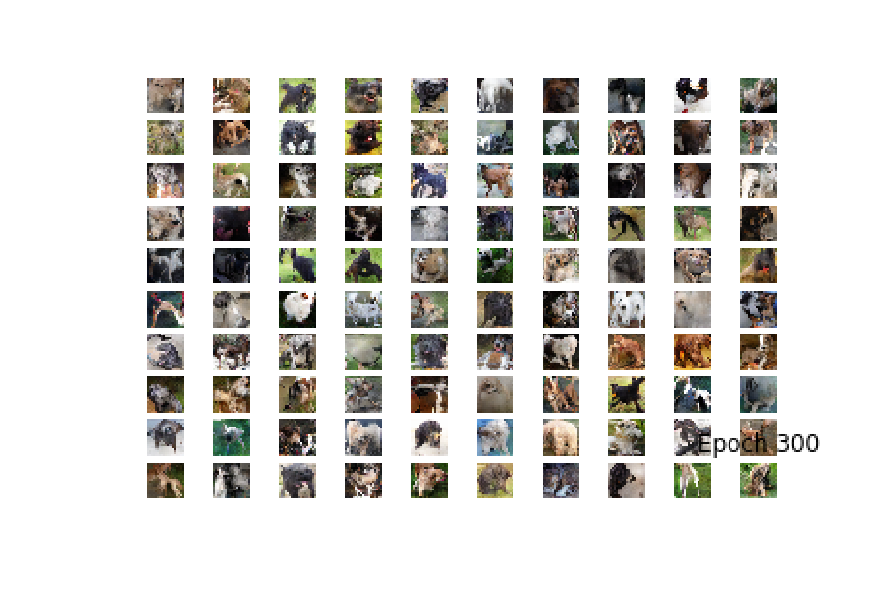

In [23]:
image = Image.open('generated_plot_e300.png')
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(image)

# Using the Generator model to generate new dog images

The generation of each image requires a point in the latent space as input.

In [24]:
def show_plot(examples, n):
    """
    This shows the plots from the GAN
    """
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i,:,:])
    plt.subplots_adjust(wspace=0.3, hspace=-0.1)
    plt.show()

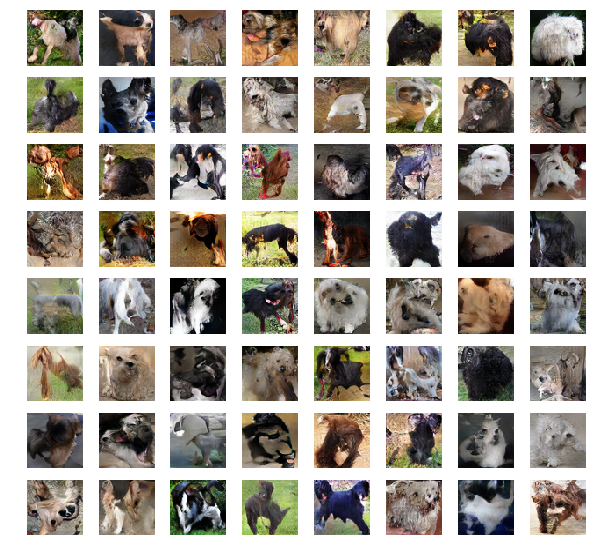

In [25]:
latent_points = generate_latent_points(200, 10000)
new_images = g_model.predict(latent_points)
new_images = (new_images+1)/2.0
show_plot(new_images, 8)

In [26]:
new_images.shape

(10000, 64, 64, 3)

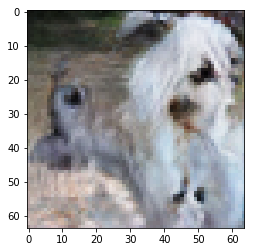

In [27]:
test = Image.fromarray((255*new_images[8383]).astype('uint8').reshape((64,64,3)))
plt.imshow(test)

# Create zip file to store the images

In [28]:
z = zipfile.PyZipFile('images.zip', mode='w')
for d in range(10000):
    dog_image = Image.fromarray((255*new_images[d]).astype('uint8').reshape((64,64,3)))
    f = str(d)+'.png'
    dog_image.save(f,'PNG')
    z.write(f)
    os.remove(f)
z.close()